In [12]:
import torch
from diffusion.datamodule import CIFAR10DataModule
from diffusion import Diffuser, Denoiser, EDM, get_default_callbacks, DeterministicSolver
import lightning as L
import matplotlib.pyplot as plt
from lightning.pytorch.loggers import WandbLogger

# Setting the seed
L.seed_everything(42)


Seed set to 42


42

## Dataset

In [2]:
cifar10 = CIFAR10DataModule()
cifar10.prepare_data()
cifar10.setup("fit")

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def plot_imgaes(images, titles):
    fig, axes = plt.subplots(2, 8, figsize=(12, 4))
    axes = axes.flatten()
    for i in range(16):
        image = images[i].permute(1, 2, 0) / 2 + 0.5 # unnormalize
        axes[i].imshow(image)
        if titles is not None:
            axes[i].set_title(titles[i])
        axes[i].axis('off')

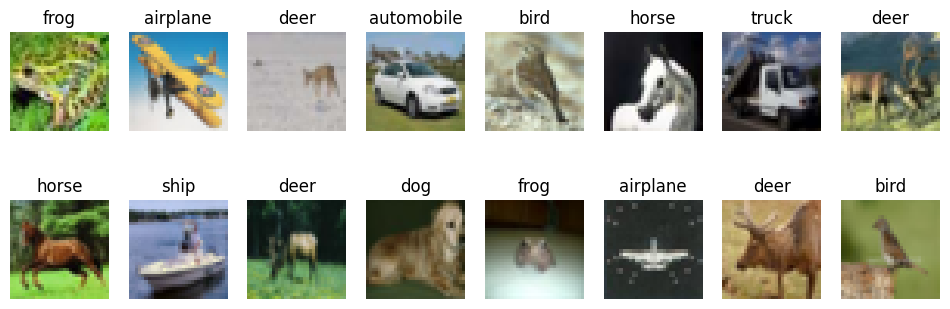

In [4]:
# Get a batch of images from CIFAR10 dataset
images, labels = next(iter(cifar10.train_dataloader()))

# Plot the images
plot_imgaes(images, [cifar10.classes[labels[i]] for i in range(16)])

## Forward Process

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

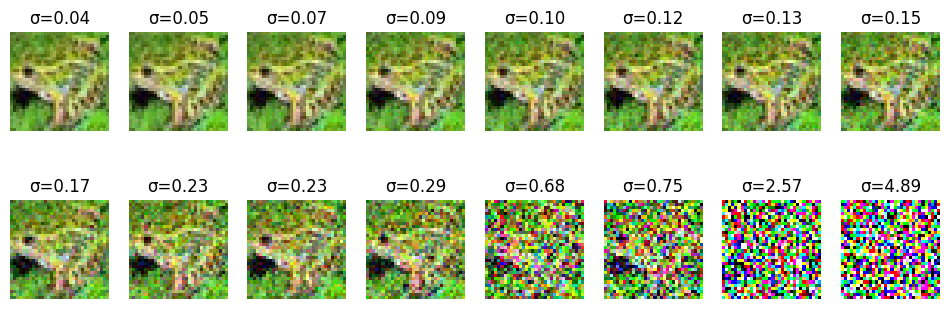

In [5]:
diffuser = Diffuser()
noisy_images, sigmas = diffuser(images[0].repeat(16, 1, 1, 1))
sorted_images, sorted_sigmas = zip(*sorted(zip(noisy_images, sigmas), key=lambda x: x[1]))

plot_imgaes(sorted_images, [f"σ={sigma:.2f}" for sigma in sorted_sigmas])


## Reverse Process

In [6]:
from diffusers import UNet2DModel

net = UNet2DModel(
    sample_size=32,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 64, 128, 128, 128, 64),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    )
)
print(net)

UNet2DModel(
  (conv_in): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=64, out_features=256, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=256, out_features=256, bias=True)
  )
  (down_blocks): ModuleList(
    (0-1): 2 x DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=256, out_features=64, bias=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(64, 6

In [7]:
import torch.nn as nn

class UNetWrapper(nn.Module):
    def __init__(self, model):
        super(UNetWrapper, self).__init__()
        self.model = model

    def forward(self, *args, **kwargs):
        outputs = self.model(*args, **kwargs)
        return outputs.sample
    
net = UNetWrapper(net)

In [8]:
denoiser = Denoiser(net)

In [9]:
denoised_images = denoiser(noisy_images, sigmas)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

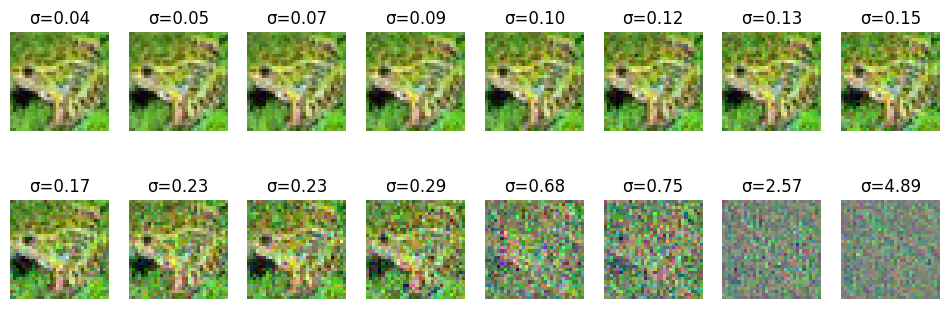

In [10]:
sorted_images, sorted_sigmas = zip(*sorted(zip(denoised_images.detach(), sigmas), key=lambda x: x[1]))

plot_imgaes(sorted_images, [f"σ={sigma:.2f}" for sigma in sorted_sigmas])

## Training

In [14]:
wandb_logger = WandbLogger(project="MNIST", name="myrun", log_model=True)

model = EDM(denoiser=denoiser, diffuser=diffuser)
wandb_logger.watch(model, log_freq=500)
callbacks = get_default_callbacks()

wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


In [32]:
trainer = L.Trainer(accelerator="gpu", max_epochs=100, logger=wandb_logger, callbacks=callbacks, accumulate_grad_batches = 16)
trainer.fit(model, cifar10)

/home/ethan/.pyenv/versions/3.11.6/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:198: Attribute 'denoiser' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoiser'])`.


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ethan/.pyenv/versions/3.11.6/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:43: attribute 'denoiser' removed from hparams because it cannot be pickled
/home/ethan/.pyenv/versions/3.11.6/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type     | Params
--------------------------------------
0 | denoiser | Denoiser | 9.9 M 
--------------------------------------
9.9 M     Trainable params
0         Non-trainable params
9.9 M     Total params
39.465    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 196: 'train_loss' reached 0.47689 (best 0.47689), saving model to './MNIST/q2s8znqd/checkpoints/epoch=0-step=196.ckpt' as top 1
Epoch 1, global step 392: 'train_loss' reached 0.31874 (best 0.31874), saving model to './MNIST/q2s8znqd/checkpoints/epoch=1-step=392.ckpt' as top 1
Epoch 2, global step 588: 'train_loss' reached 0.28885 (best 0.28885), saving model to './MNIST/q2s8znqd/checkpoints/epoch=2-step=588.ckpt' as top 1
Epoch 3, global step 784: 'train_loss' reached 0.27347 (best 0.27347), saving model to './MNIST/q2s8znqd/checkpoints/epoch=3-step=784.ckpt' as top 1
Epoch 4, global step 980: 'train_loss' reached 0.26056 (best 0.26056), saving model to './MNIST/q2s8znqd/checkpoints/epoch=4-step=980.ckpt' as top 1
Epoch 5, global step 1176: 'train_loss' reached 0.25311 (best 0.25311), saving model to './MNIST/q2s8znqd/checkpoints/epoch=5-step=1176.ckpt' as top 1
/home/ethan/.pyenv/versions/3.11.6/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: De

Code for resume Training

```python
best_ckpt_path = './MNIST/q2s8znqd/checkpoints/epoch=5-step=1176.ckpt'
model = EDM.load_from_checkpoint(best_ckpt_path, denoiser = denoiser)
wandb_logger = WandbLogger(project="MNIST", name="myrun", resume="must", log_model=True)
callbacks = get_default_callbacks()
trainer = L.Trainer(accelerator="gpu", max_epochs=100, logger=wandb_logger, callbacks=callbacks, accumulate_grad_batches = 16)
trainer.fit(model, cifar10, ckpt_path=best_ckpt_path)
```

In [13]:
best_ckpt_path = './MNIST/q2s8znqd/checkpoints/epoch=17-step=38676.ckpt'
model = EDM.load_from_checkpoint(best_ckpt_path, denoiser=denoiser)
wandb_logger = WandbLogger(project="MNIST", name="myrun", resume="must", log_model=True)
callbacks = get_default_callbacks()

trainer = L.Trainer(accelerator="gpu", max_epochs=200, logger=wandb_logger, callbacks=callbacks)
trainer.fit(model, cifar10, ckpt_path=best_ckpt_path)

Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ethan/.pyenv/versions/3.11.6/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:72: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


Files already downloaded and verified
Files already downloaded and verified


You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: shambles. Use `wandb login --relogin` to force relogin


Problem at: /home/ethan/.pyenv/versions/3.11.6/lib/python3.11/site-packages/wandb/sdk/wandb_init.py 848 getcaller


UsageError: You provided an invalid value for the `resume` argument. The value 'must' is not a valid option for resuming a run (odnogtjl) that does not exist. Please check your inputs and try again with a valid run ID. If you are trying to start a new run, please omit the `resume` argument or use `resume='allow'`.

Let's see how `denoiser` is trained to remove noise from the images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

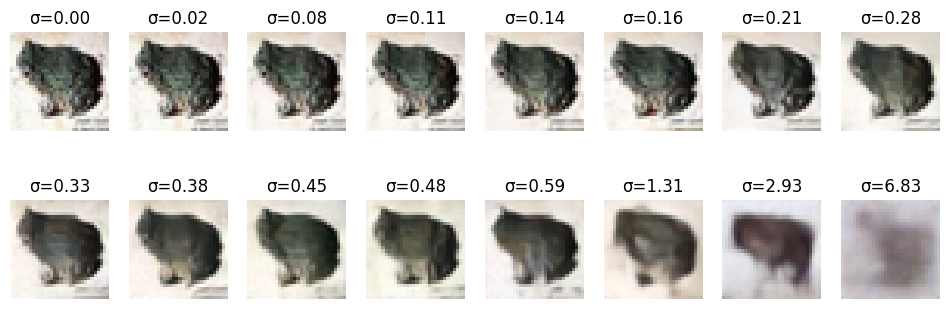

In [40]:
denoised_images = model.denoiser.cpu()(noisy_images, sigmas)
sorted_images, sorted_sigmas = zip(*sorted(zip(denoised_images.detach(), sigmas), key=lambda x: x[1]))

plot_imgaes(sorted_images, [f"σ={sigma:.2f}" for sigma in sorted_sigmas])

## Inference

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

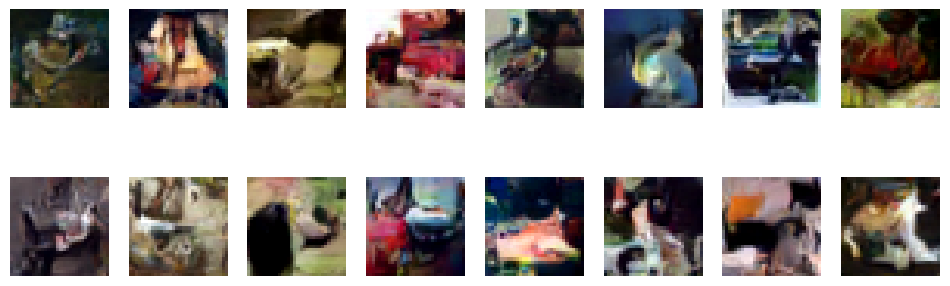

In [30]:
solver = DeterministicSolver(dtype=torch.float32)
x0 = torch.randn(16, 3, 32, 32, device="cuda")

model=model.cuda()
model.eval()

with torch.no_grad():
    xT = solver.solve(model, x0)   
    
plot_imgaes(xT.cpu(), None) 